# Recommender Systems
As part of the course *Recommender Systems*, we were asked to create a music recommender system. We were provided with a dataset coming from the Kaggle website,  https://www.kaggle.com/c/dsg17-online-phase/.

The goal was to use a recommender system to predict a song's probability to be listened to by a given user.
First, we explored our dataset to gain a better understanding. Then, we tested different recommender models and evaluated their performance. Finally, we selected and developed one model that we used to try to win the competition.

## 1. Loading the Libraries

In [ ]:
# Hide output of this cell
%%capture

# Install packages
!pip install surprise

# Import packages
import numpy as np
import random
import pandas as pd
import os
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import glob
import pytz
from datetime import datetime
from google.colab import drive
from scipy.sparse import coo_matrix
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split as train_test_split_sklearn
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from surprise import SVD, SVDpp, KNNBaseline, BaselineOnly, KNNBasic, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, cross_validate
from itertools import permutations
import datetime
import seaborn as sns
import heapq

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Since we were both working simultaneously and the model training took almost a day in some cases, we chose Google Colab to develop the code for this project.

## 2. Loading the Dataset

**Data Source** 

https://www.kaggle.com/c/dsg17-online-phase/ 


**Data fields**
- media_id: identifiant of the song listened by the user
- album_id: identifiant of the album of the song
- media_duration: duration of the song
- user_gender:  gender of the user
- user_id:  anonymized id of the user
- context_type: type of content where the song was listened: playlist, album ...
- release_date: release date of the song with the format YYYYMMDD
- ts_listen: timestamp of the listening in UNIX time
- platform_name: type of operating system
- platform_family: type of device
- user_age: age of the user
- listen_type: if the songs was listened in a flow or not
- artist_id: identifiant of the artist of the song
- genre_id: identifiant of the genre of the song

*Variable of Interest*
- is_listened: 1 if the track was listened, 0 otherwise

In [ ]:
path = '/content/drive/MyDrive/Collaborative Filtering/Recommender_Systems/RecommenderSystem_Storke_Zimmermann'
train = pd.read_csv(f'{path}/data/train.csv')
test = pd.read_csv(f'{path}/data/test.csv')
train.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1


## 3. Data Transformation

In [ ]:
## Global information about data types 
train.info(null_counts = True) ## null_counts = True: to count the number of entries

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7558834 entries, 0 to 7558833
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype
---  ------           --------------    -----
 0   genre_id         7558834 non-null  int64
 1   ts_listen        7558834 non-null  int64
 2   media_id         7558834 non-null  int64
 3   album_id         7558834 non-null  int64
 4   context_type     7558834 non-null  int64
 5   release_date     7558834 non-null  int64
 6   platform_name    7558834 non-null  int64
 7   platform_family  7558834 non-null  int64
 8   media_duration   7558834 non-null  int64
 9   listen_type      7558834 non-null  int64
 10  user_gender      7558834 non-null  int64
 11  user_id          7558834 non-null  int64
 12  artist_id        7558834 non-null  int64
 13  user_age         7558834 non-null  int64
 14  is_listened      7558834 non-null  int64
dtypes: int64(15)
memory usage: 865.0 MB


**genre_id**

In [ ]:
## Number of unique genres
print(f'There are {train.genre_id.nunique()} different genres in this dataset.')

## Make genre_id a categorical variable
train['genre_id'] = train['genre_id'].astype("category")

There are 2922 different genres in this dataset.


**ts_listened**

In [ ]:
## Transform Unix timestamp into datetime
train['time_listened'] = pd.to_datetime(train['ts_listen'], unit='s')

## Create 2 new variables 'date_listened' and 'weekday_listened'
# 'date_listened'
train['date_listened'] = train['time_listened'].dt.date
train['date_listened'] = pd.to_datetime(train['date_listened'], format='%Y-%m-%d')

# 'weekday_listened'
train['weekday_listened'] = train['time_listened'].dt.weekday
train['weekday_listened'] = train['weekday_listened'].astype('category')

## Visualise the results
train[['ts_listen', 'time_listened']].head(3)

,ts_listen,time_listened
0,1480597215,2016-12-01 13:00:15
1,1480544735,2016-11-30 22:25:35
2,1479563953,2016-11-19 13:59:13


**Media_id**

In [ ]:
## Number of unique songs
print(f'There are {train.media_id.nunique()} different songs in this dataset.')

## Make media_id a categorical variable
train['media_id'] = train['media_id'].astype("category")

There are 452975 different songs in this dataset.


**album_id**

In [ ]:
## Number of unique albums
print(f'There are {train.album_id.nunique()} different albums in this dataset.')

## Make album_id a categorical variable
train['album_id'] = train['album_id'].astype("category")

There are 151471 different albums in this dataset.


**context_type**

In [ ]:
## Number of unique contexts
print(f'There are {train.context_type.nunique()} different contexts (albums, playlists, etc.) in this dataset.')

## Make context_type a categorical variable
train['context_type'] = train['context_type'].astype("category")

There are 74 different contexts (albums, playlists, etc.) in this dataset.


**release_date**

This variable contains noise, being a date in 3000. Therefore, we had to replace the last "realistic" date before this noisy data point. 

In [ ]:
## Noise
print(train['release_date'].max()) ## 30000101

## Find the last occurence before 30000101
print(sorted(list(train['release_date'].unique()))[-2]) ## 20170313

In [ ]:
## Transform into NaN if date is after 20170313
train['release_date'] = train['release_date'].astype('str') ## to avoid being changed into integer
train['release_date'] = np.where(train['release_date'] > '20170313', np.nan, train['release_date']) ## to change due to previous cleaning

## Transform into date format
train['release_date'] = pd.to_datetime(train['release_date'], format='%Y%m%d')

**platform_name**

In [ ]:
## Number of unique platforms
print(f'There are {train.platform_name.nunique()} different platforms in this dataset.')
## 0,1,2: but we don't know their meaning

## Make platform_name a categorical variable
train['platform_name'] = train['platform_name'].astype("category")

There are 3 different platforms in this dataset.


**platform_family**

In [ ]:
## Number of unique platform families
print(f'There are {train.platform_family.nunique()} different platform families in this dataset.')
## 0,1,2: but we don't know their meaning

## Make platform_family a categorical variable
train['platform_family'] = train['platform_family'].astype("category")

There are 3 different platform families in this dataset.


**listen_type**

In [ ]:
print(f'There are {train.listen_type.nunique()} different listen types in this dataset.')

## Binary Variable: 
## Make listen_type a categorical variable
train['listen_type'] = train['listen_type'].astype("category")

There are 2 different listen types in this dataset.


**user_gender**

In [ ]:
print(f'There are {train.user_gender.nunique()} different user genders in this dataset.')

## Binary Variable: 
## Make user_gender a categorical variable
train['user_gender'] = train['user_gender'].astype("category")

There are 2 different user genders in this dataset.


**user_id**

In [ ]:
print(f'There are {train.user_id.nunique()} different users in this dataset.')

## Make user_id a categorical variable
train['user_id'] = train['user_id'].astype("category")

There are 19918 different users in this dataset.


**artist_id**

In [ ]:
print(f'There are {train.artist_id.nunique()} different artists in this dataset.')

## Make artist_id a categorical variable
train['artist_id'] = train['artist_id'].astype("category")

There are 67142 different artists in this dataset.


**is_listened**

In [ ]:
print(f'The target variable "is_listened" takes {train.is_listened.nunique()} different values.')

## Our variable of interest & binary variable
## Make is_listened a categorical variable
train['is_listened'] = train['is_listened'].astype("category")

The target variable "is_listened" takes 2 different values.


## 4. Exploratory Analysis

### Size of the Dataset

In [ ]:
## Total number of records
len(train)

7558834

There are over 7.5 million songs in the train dataset.

### Users

#### Activity /Frequency of Users

In [ ]:
## Count the number of songs (listened and non-listened) per user

## Group by the number of songs 
## & count the number of users that lisstened to that number of songs
df_usr_nsong = train[['media_id', 'user_id']].groupby('user_id').count().reset_index( ## count number of songs per user
                          ).groupby('media_id').count().reset_index() ## group & count number of user per number of songs

## Rename columns
df_usr_nsong.rename(columns = {'media_id': 'nb_songs', 
                               'user_id': 'nb_users'}, inplace = True)

In [ ]:
df_usr_nsong

,nb_songs,nb_users
0,1,252
1,2,127
2,3,113
3,4,75
4,5,95
...,...,...
2022,5426,1
2023,5581,1
2024,6211,1
2025,6240,1


#### Age of Users


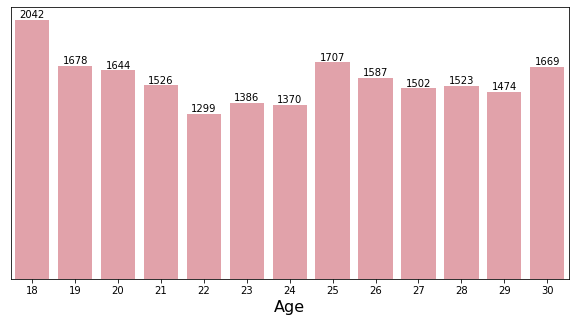

In [ ]:
## Select and aggregate data
usr_age = train[['user_id', 'user_age']].groupby('user_age').nunique().reset_index()

## Plot results
plt.figure(figsize=(10,5))
gph2 = sns.barplot(x = 'user_age',
                   y = 'user_id',
                   data = usr_age,
                   color = '#eb97a3')

## Add labels
plt.xlabel("Age", size=16)
plt.ylabel("Number of Users", size=16)

## Disable Y-axis
ax = plt.gca() ## Get the Axes
ax.get_yaxis().set_visible(False) ## Hide Y-Axis

## Add total per bar
## Source: https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
for bar in gph2.patches:
    gph2.annotate(format(bar.get_height(), '.0f'), ## total per bar
                  (bar.get_x() + bar.get_width() / 2, ## position
                   bar.get_height()), ## position
                  ha='center', va='center', ## position
                  size=10, ## font size
                  xytext=(0, 5), ## position of number above bar
                  textcoords='offset points')


plt.show()

#### Gender

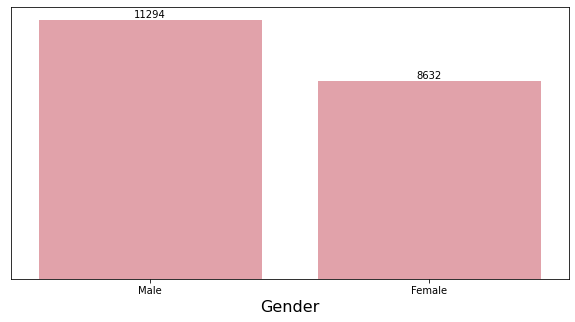

In [ ]:
## Select and aggregate data
usr_gender = train[['user_id', 'user_gender']].groupby('user_gender').nunique().reset_index()

## Plot results
plt.figure(figsize=(10,5))
gph3 = sns.barplot(x = 'user_gender',
                   y = 'user_id',
                   data = usr_gender,
                   color = '#eb97a3')

## Add labels
plt.xlabel("Gender", size=16)
plt.ylabel("Number of Users", size=16)

## Disable Y-axis
ax = plt.gca() ## Get the Axes
ax.get_yaxis().set_visible(False) ## Hide Y-Axis

## Change labels (0,1 -> Man, Woman)
gph3.set_xticklabels(('Male', 'Female'))

## Add total per bar
## Source: https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
for bar in gph3.patches:
    gph3.annotate(format(bar.get_height(), '.0f'), ## total per bar
                  (bar.get_x() + bar.get_width() / 2, ## position
                   bar.get_height()), ## position
                  ha='center', va='center', ## position
                  size=10, ## font size
                  xytext=(0, 5), ## position of number above bar
                  textcoords='offset points')


plt.show()

#### Number of User Per Weekday

In [ ]:
## Get the weekdays
train['weekday_listened'] = train['time_listened'].dt.weekday
train['weekday_listened'] = train['weekday_listened'].astype('category')

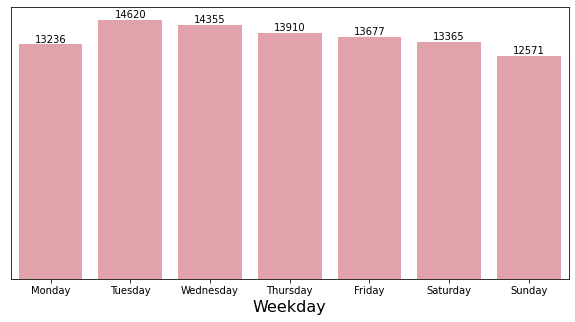

In [ ]:
## Select and aggregate data
wkd = train[['weekday_listened', 'user_id']].groupby('weekday_listened').nunique().reset_index()

## Plot results
plt.figure(figsize=(10,5))
gph4 = sns.barplot(x = 'weekday_listened',
                   y = 'user_id',
                   data = wkd,
                   color = '#eb97a3')

## Add labels
plt.xlabel("Weekday", size=16)
plt.ylabel("Number of Users", size=16)

## Disable Y-axis
ax = plt.gca() ## Get the Axes
ax.get_yaxis().set_visible(False) ## Hide Y-Axis

## Change labels (0,1,2,3,4 -> Monday, Tuesday, ...)
gph4.set_xticklabels(('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))

## Add total per bar
## Source: https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
for bar in gph4.patches:
    gph4.annotate(format(bar.get_height(), '.0f'), ## total per bar
                  (bar.get_x() + bar.get_width() / 2, ## position
                   bar.get_height()), ## position
                  ha='center', va='center', ## position
                  size=10, ## font size
                  xytext=(0, 5), ## position of number above bar
                  textcoords='offset points')


plt.show()

### Listening Time

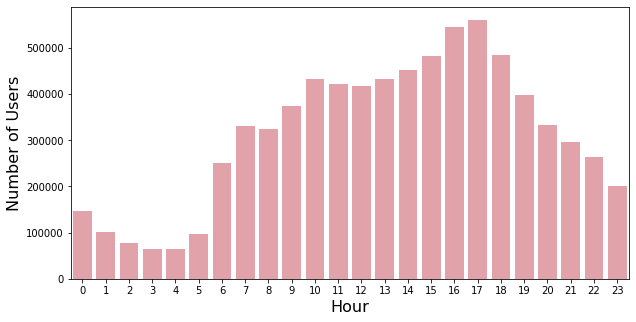

In [ ]:
train['hour_listened'] = train['time_listened'].dt.hour
train['hour_listened'] = train['hour_listened'].astype('category')

## Select and aggregate data
hr = train[['hour_listened', 'user_id']].groupby('hour_listened').count().reset_index()

## Plot results
plt.figure(figsize=(10,5))
gph5 = sns.barplot(x = 'hour_listened',
                   y = 'user_id',
                   data = hr,
                   color = '#eb97a3')

## Add labels
plt.xlabel("Hour", size=16)
plt.ylabel("Number of Users", size=16)


plt.show()

### Music Duration

In [ ]:
## Minimum duration
print('min:', train['media_duration'].min()) ## not possible

## Maximum duration
print('max:', train['media_duration'].max()) ## way too irreal

## Mean duration
print('mean:', round(train['media_duration'].mean(), 1))

## Maximum duration
print('quartile:', train['media_duration'].quantile(q = (0.25, 0.5, 0.75)))

min: 0
max: 65535
mean: 231.2
quartile: 0.25    196.0
0.50    222.0
0.75    254.0
Name: media_duration, dtype: float64


### Users in testset

Each of the users in the test dataset only appears once.

In [ ]:
test['user_id'].nunique() == len(test['user_id'])

True

In [ ]:
users_list_test = test['user_id'].tolist()
users_list_train = train['user_id'].tolist()
unique_users_list_train = set(users_list_train)

new_users = []
for user in users_list_test:
  if not user in unique_users_list_train:
    new_users.append(user)
print(f'There are {len(new_users)} users in the test dataset that no training data is available for.')

There are 0 users in the test dataset that no training data is available for.


We have training data for each of the test users we are supposed to predict on, which is a great starting point as this will likely boost our prediction accuracy.

In [ ]:
# Do not run this cell again (it takes long time)
users_list_train_reduced = [user for user in users_list_train if user in users_list_test]

freq_testusers_in_train = Counter(users_list_train_reduced)
freq_test_in_train= {}
for key, value in freq_testusers_in_train.items():
  freq_test_in_train[key] = value
df = pd.DataFrame(freq_test_in_train, index=[0]).T.reset_index()
df.columns = ['user_id', 'freq']
df.to_csv(f'{path}/stored_freqs_testuser_in_train.csv', index = False)

In [ ]:
freqs_testuser_in_train = pd.read_csv(f'{path}/data/stored_freqs_testuser_in_train.csv')
freqs_testuser_in_train.freq.describe()

count    19918.000000
mean       379.497640
std        508.267514
min          1.000000
25%         66.000000
50%        197.000000
75%        495.000000
max       6317.000000
Name: freq, dtype: float64

In [ ]:
dtestusr = freqs_testuser_in_train.value_counts('freq').reset_index().sort_values('freq').head()
# rename first column 
dtestusr.columns.values[0] = "Nb Songs" 

# rename second column 
dtestusr.columns.values[1] = "Nb Users" 
dtestusr

,Nb Songs,Nb Users
0,1,252
1,2,127
2,3,113
28,4,75
8,5,95


Of the 19'918 users in the test set, 252 have only ever listened to one song, 127 to 2, 113 to 3, etc. While prediction on them is likely poor, the average test user has listened to 379 songs. Thus, we have quite a lot of data on them and predictions should work well.

### Dropping One-Time Users

In [ ]:
one_time_users = train[['user_id', 'media_id']].groupby('user_id').count().reset_index()
one_time_users = one_time_users[one_time_users['media_id'] == 1]['user_id'].tolist()
train_reduced = train[~train['user_id'].isin(one_time_users)]

In [ ]:
## Data preparation was done separately due to a lack of RAM in the notebook
## This cell is just here for transparency reasons (the code is the same)

## Do Not Run This Cell

## Load the Data
train = pd.read_csv(f'{path}/data/train.csv') ## full dataset

## Count the number of listenings per song per user
df_u = train.groupby(['user_id', 'media_id']).sum()['is_listened'].reset_index()
df_u.rename(columns = {'is_listened': 'nb_listened'}, inplace = True)
print('user done')

## Get the total opportunities of listening of song
df_o = train.groupby(['user_id', 'media_id']).count()['is_listened'].reset_index()
df_o.rename(columns = {'is_listened': 'nb_opportunities'}, inplace = True)
print('opportunity done')

## Get the proportion of listening
df_p = train.groupby(['user_id', 'media_id']).mean()['is_listened'].reset_index()
df_p.rename(columns = {'is_listened': 'nb_prop'}, inplace = True)
print('proportion done')

df_final = df_u.merge(df_o, on = ['user_id', 
                                  'media_id']).merge(df_p, on = ['user_id', 'media_id'])
print('merging done')


## Merge to get information about music
df_final = df_final.merge(train[['media_id', 
                                 'release_date', 
                                 'media_duration', 
                                 'genre_id', 
                                 'album_id']].drop_duplicates(["media_id"]), on = 'media_id')

## Add new column (year)
df_final['release_year'] = df_final['release_date'].astype(str).str.slice(0, 4).astype(int)
print('merging & media done')

## Merge to get information about user
df_final = df_final.merge(train[['user_id', 
                                 'user_gender', 
                                 'user_age']].drop_duplicates(["user_id"]), on = 'user_id')
print('merging & user done')
df_final.to_csv('data_prep_OneTimeUsers_Result.csv', sep = ',')

print('final dataset created')

In [ ]:
## From the output above, we re-defined our dataset and dropped "One-Time Users"

## Loading data
df = pd.read_csv(f'{path}/data/data_prep_OneTimeUsers_Result.csv')
## Drop first column
df.drop(columns=df.columns[0], axis=1, inplace=True)

# Drop "One-Time Users"
df = df[~df['user_id'].isin(heavy_users)]
df

,user_id,media_id,nb_listened,nb_opportunities,nb_prop,release_date,media_duration,genre_id,album_id,release_year,user_gender,user_age
0,0,211678,7,7,1.0,20070619,360,2,40902,2007,0,26
1,0,211796,1,1,1.0,20070619,254,2,40912,2007,0,26
2,0,238286,1,1,1.0,20030527,196,18,42872,2003,0,26
3,0,286191,1,1,1.0,20061212,230,9,46627,2006,0,26
4,0,304849,1,1,1.0,20071004,322,2,48047,2007,0,26
...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,4661,682789,1,1,1.0,20050920,188,50,82323,2005,1,26
1048571,4661,745532,1,1,1.0,20010423,271,7,88383,2001,1,26
1048572,4661,858207,0,1,0.0,19940927,258,7,98225,1994,1,26
1048573,4661,909611,0,1,0.0,20060605,174,7,102586,2006,1,26


## Our Prediction Models to Win the Competition

### Comparing SVD, KNN and Baseline on full dataset treating 'is_listened' as explicit rating

To get a first baseline accuracy, we compared the accuracy and performance of three built-in algorithms of the surprise package on the full dataset, treating 'is_listened' as an explicit rating:


*   Probabilistic Matrix Factorization
*   A basic collaborative filtering algorithm taking into account a baseline rating.
*   Algorithm predicting the baseline estimate for given user and item.





In [ ]:
# Compare performance of three different algorithms
reader = Reader(rating_scale = (0, 1))

data_full_is_listened = Dataset.load_from_df(train[['user_id', 'media_id', 'is_listened']], reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNBaseline(), BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_full_is_listened, measures=['RMSE'], cv = 3, verbose = False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index = ['Algorithm']))
    benchmark.append(tmp)
    
#pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  
df_benchmark = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
df_benchmark.to_csv(f'{path}/benchmark_smaller.csv')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [ ]:
df_benchmark = pd.read_csv(f'{path}/data/benchmark_smaller.csv')
df_benchmark

,Algorithm,test_rmse,fit_time,test_time
0,SVD,0.403476,334.573660,43.606699
1,BaselineOnly,0.406610,45.696861,34.071112
2,KNNBaseline,0.411336,630.961869,3014.402711


As we can see, the baseline algorithm is much faster and has almost the same accuracy as SVD.

### First Model: "nb_prop"

Since the above algorithms are intended for use with explicit ratings, we created a new rating variable (using the proportion of the time a user did not skip a song) and ran the BaselineOnly model on the dataset excluding one-time users and the full dataset.

In [ ]:
# Read in CSV file as surprise dataset 
## Reduced dataset, which excludes one-time users
data_reduced_nb_prop = Dataset.load_from_df(df[['user_id', 'media_id', 'nb_prop']], reader)

# Split into 80% train and 20% test set
trainset, testset = train_test_split(data_reduced_nb_prop, test_size = .2)

# We will use the baseline algorithm
algo = BaselineOnly()

# Train the algorithm on the trainset, and predict 'nb_prop' for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Compute RMSE of predictions
accuracy.rmse(predictions) ## 35%

Estimating biases using als...
RMSE: 0.3497


0.349701154441177

In [ ]:
# Dataset including one-time users
opps = pd.read_csv(f'{path}/data/data_prep.csv')
opps_min = opps['nb_prop'].min()
opps_max = opps['nb_prop'].max()

# Read in csv file as surprise dataset
reader = Reader(rating_scale = (opps_min, opps_max))
data = Dataset.load_from_df(opps[['user_id', 'media_id', 'nb_prop']], reader)

# Split into train and test set
trainset, testset = train_test_split(data, test_size = .2)

# We will use the baseline algorithm
algo = BaselineOnly()

# Train the algorithm on the trainset, and predict 'nb_prop' for the testset
algo.fit(trainset)
predictions = algo.test(testset) 

# Compute RMSE of predictions
accuracy.rmse(predictions) ## 34.9%

Estimating biases using als...
RMSE: 0.3494


0.34943948813097103

The model trained on the full dataset performed slightly better with an excellent RMSE of around 34.9%.

### Second Model: "good_song"


Our second model is trained on yet another new rating variable, "good_song", for which the proportion of the time a user did not skip the song is binary (using .5 as a threshold). Here, one-time users were excluded.

In [ ]:
## Add new Column to say whether the user liked or did not like the song
df['good_song'] = np.where(df['nb_prop']>=0.5, 1, 0)

## if the user listened to the song more than 50% of the times, 
## we considered it is a good song.

# Read in csv file as surprise dataset
df_good_song = Dataset.load_from_df(df[['user_id', 'media_id', 'good_song']], reader)

# Split into train and test set
trainset, testset = train_test_split(df_good_song, test_size = .2)

# We'll use the baseline algorithm.
algo = BaselineOnly()

# Train the algorithm on the trainset, and predict 'good_song' for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Compute RMSE of predictions
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.3733


0.3733340526830752

This one has a slightly higher RMSE of 37%, so we would stick to the previous model.

### Third Model: "is_listened"

Lastly, since it is intended for implicit rating, we tried the SVD++ algorithm, which is an extension of SVD, on the full dataset again.

In [ ]:
# Split into train and test set
trainset, testset = train_test_split(data_full_is_listened, test_size = .2)

# We will use the SVD++ algorithm
algo = SVDpp()

# Train the algorithm on the trainset, and predict 'is_listened' for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Compute RMSE of predictions
accuracy.rmse(predictions) # RMSE: 0.4032

RMSE: 0.4032


0.4032105995796852

The algorithm designed for implicit ratings took almost a day to run and it performs worse than the previously discussed ones on our created implicit rating. Therefore, we decided to stick to the baseline algorithm trained on the implicit rating 'nb_prop' and the full dataset to predict on the test set.

### Testing Our Final Model

In [ ]:
# Use trained algorithm to predict on the test set
preds = []
for _, row in test.iterrows():
  pred = algo.predict(row.user_id, row.media_id)
  preds.append(pred.est)

test['prediction'] = preds
test['prediction_binary'] = np.where(test['prediction'] > .5, 1, 0)
test.to_csv(f'{path}/data/final_submission.csv', index = False)
test = pd.read_csv(f'{path}/data/final_submission.csv')
test.sort_values('user_id')

,sample_id,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,prediction,prediction_binary
14561,14561,0,1480614542,117678828,12219078,1,20151012,0,2,190,1,0,0,468920,26,0.927605,1
6026,6026,0,1480614639,103870206,10804138,1,20150716,0,2,237,1,1,1,4052518,27,0.922363,1
9627,9627,0,1480609115,110692486,11516526,1,20151204,1,2,274,1,0,2,5328949,19,0.989921,1
6064,6064,3645,1480629074,4628432,425785,1,20091102,0,0,479,1,0,3,57456,20,0.916864,1
8065,8065,14,1480571507,71152679,6985314,1,20130930,0,0,229,1,1,4,1435566,19,0.647138,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16220,16220,0,1480200593,134443920,14333694,1,20161118,0,0,221,1,1,19913,256681,23,0.667902,1
14757,14757,18,1478288725,3129568,301763,1,20001231,0,0,184,1,1,19914,165,18,0.671172,1
16969,16969,1153,1478016326,71016062,6971220,1,20120703,1,0,346,1,1,19915,5880172,24,0.656150,1
4992,4992,0,1478017434,121448102,12690006,1,20160325,0,0,193,1,0,19916,776,25,0.620644,1


Using the best performing model, we created a prediction of how likely a user will be to not skip a given song for all songs in the test set, which can be found in the file "final_submission.csv" (the column "prediction" is showing the likelihood that a user will not skip the song and the column "prediction_binary" the final prediction).

## Additional Work

Before fitting different surprise models, we actually thought about how we could build our own model to predict whether the users in the test set will listen to the proposed song. However, since the individual steps turned out to be very time-consuming, we left this after receiving a list of the 100 most similar songs and 100 most similar users for all songs and users in the train set.

Find 100 most similar songs

In [ ]:
# Inspired by https://github.com/benfred/bens-blog-code/blob/cb1ce7094ffb8149d5697408036620837bd8b70e/distance-metrics/calculate_similar.py#L68

In [ ]:
# group users and songs and count combinations
count_series = train[['user_id', 'artist_id', 'media_id', 'is_listened']].groupby(['user_id', 'media_id']).size()
user_song_plays = count_series.to_frame(name = 'plays').reset_index()
user_song_plays['user_id'] = user_song_plays['user_id'].astype('category')
user_song_plays['media_id'] = user_song_plays['media_id'].astype('category')

In [ ]:
def get_largest(row, N=100):
    if N >= row.nnz:
        best = zip(row.data, row.indices)
    else:
        ind = np.argpartition(row.data, -N)[-N:]
        best = zip(row.data[ind], row.indices[ind])
    return sorted(best, reverse=True)

def cosine(plays):
    normalized = normalize(plays)
    return normalized.dot(normalized.T)    

def calculate_similar_songs(similarity, songs, song):
    neighbours = similarity[song]
    top = get_largest(neighbours)
    return [(songs[other], score, i) for i, (score, other) in enumerate(top)]

In [ ]:
plays = coo_matrix((user_song_plays['plays'],
                    (user_song_plays['media_id'].cat.codes.copy(),
                     user_song_plays['user_id'].cat.codes.copy())))
songs = dict(enumerate(user_song_plays['media_id'].cat.categories))
user_count = user_song_plays.groupby('media_id').size()
to_generate = sorted(list(songs), key=lambda x: -user_count[x])
similarity = cosine(plays)

names , others, scores, ranks = [], [], [], []

for song in to_generate:
  name = songs[song]
  for other, score, rank in calculate_similar_songs(similarity, songs, song):
    names.append(name)
    others.append(other)
    scores.append(score)
    ranks.append(rank)

most_similar_songs = pd.DataFrame({'media_id': names, 'media_id_similar': others, 'score': scores, 'rank': ranks})
most_similar_songs.to_csv(f'{path}/data/100 similar songs.csv', index = False)

In [ ]:
# Reload from saved file
most_similar_songs = pd.read_csv(f'{path}/data/100 similar songs.csv')
most_similar_songs.head()

,media_id,media_id_similar,score,rank
0,132434634,132434634,1.000000,0
1,132434634,125890431,0.496155,1
2,132434634,122927594,0.458171,2
3,132434634,129121520,0.422151,3
4,132434634,134748108,0.406118,4


Due to the large size of the resulting file (> 1.5 GB), it is not included in the submission folder.

Find 100 most similar users

In [ ]:
reader = Reader(rating_scale = (0, 1))
data = Dataset.load_from_df(train[['user_id', 'media_id', 'is_listened']], reader)

# Split into train and test set
trainset, testset = train_test_split(data, test_size = .2)


sim_options = {'name': 'cosine',
               'user_based': True
               }
k = 100

model = KNNBasic(sim_options=sim_options)
model.fit(trainset)
simsMatrix = model.compute_similarities()

# Get top 100 similar users to our test subject
# (Alternate approach would be to select users up to some similarity threshold - try it!)
users = dict(enumerate(user_song_plays['user_id'].cat.categories))

neighbours = {}
k = 100
for user in users:
  try:
    testUserInnerID = trainset.to_inner_uid(user)
    similarityRow = simsMatrix[testUserInnerID]

    similarUsers = []
    for innerID, score in enumerate(similarityRow):
        if (innerID != testUserInnerID):
            similarUsers.append( (innerID, score) )

    kNeighbors = heapq.nlargest(k, similarUsers, key=lambda t: t[1])
    neighbours[user] = list(kNeighbors)
  except:
    print('User not in trainset.')
    pass

df_save = pd.DataFrame(neighbours)
df_save.to_csv(f'{path}/data/100 neighbours.csv', index = False)

In [ ]:
neighbours = pd.read_csv(f'{path}/data/100 neighbours.csv')
neighbours

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,19866,19867,19868,19869,19870,19872,19873,19875,19876,19877,19881,19883,19884,19885,19886,19887,19888,19889,19890,19891,19892,19893,19894,19895,19896,19897,19898,19899,19900,19901,19903,19905,19906,19909,19910,19912,19914,19915,19916,19917
0,"(46, 1.0)","(32, nan)","(22, 1.0)","(2, nan)","(78, nan)","(46, nan)","(26, nan)","(5, nan)","(16, 1.0)","(46, nan)","(125, 1.0)","(50, nan)","(522, 1.0)","(14, nan)","(94, nan)","(54, nan)","(314, 1.0)","(51, 1.0)","(94, nan)","(104, 1.0)","(54, nan)","(331, 1.0)","(5, nan)","(94, nan)","(66, nan)","(97, 1.0)","(1127, 1.0)","(78, nan)","(160, 1.0)","(46, nan)","(38, nan)","(48, nan)","(78, nan)","(46, 1.0)","(3765, 1.0)","(360, 1.0)","(48, 1.0)","(94, nan)","(48, nan)","(78, nan)",...,"(0, 0.0)","(54, nan)","(25, nan)","(94, nan)","(0, 0.0)","(0, 0.0)","(184, 1.0)","(30, 0.0)","(30, 0.0)","(0, 0.0)","(34, nan)","(54, nan)","(134, 1.0)","(71, 1.0)","(5, nan)","(0, 0.0)","(2536, 1.0)","(0, 0.0)","(0, 0.0)","(34, nan)","(94, nan)","(70, nan)","(46, nan)","(56, nan)","(210, 1.0)","(58, nan)","(30, 0.0)","(16, 1.0)","(0, 0.0)","(94, nan)","(2240, 1.0)","(0, 0.0)","(38, nan)","(338, 1.0)","(0, 0.0)","(37, nan)","(30, nan)","(0, 0.0)","(117, 1.0)","(18, 1.0)"
1,"(104, 1.0)","(46, 1.0)","(41, 1.0)","(54, nan)","(1220, 1.0)","(32, nan)","(32, nan)","(144, 1.0)","(48, 1.0)","(22, nan)","(3081, 1.0)","(6000, 1.0)","(677, 1.0)","(94, nan)","(54, nan)","(32, nan)","(564, 1.0)","(32, nan)","(50, nan)","(222, 1.0)","(32, nan)","(631, 1.0)","(2811, 1.0)","(86, nan)","(31, 1.0)","(524, 1.0)","(1842, 1.0)","(80, nan)","(176, 1.0)","(84, nan)","(60, nan)","(2073, 1.0)","(56, nan)","(75, 1.0)","(6050, 1.0)","(459, 1.0)","(50, 1.0)","(54, nan)","(2330, 1.0)","(48, nan)",...,"(1, 0.0)","(26, nan)","(192, 1.0)","(82, nan)","(1, 0.0)","(1, 0.0)","(211, 1.0)","(34, 0.0)","(34, 0.0)","(1, 0.0)","(26, nan)","(37, nan)","(663, 1.0)","(384, 1.0)","(82, 1.0)","(1, 0.0)","(13751, 1.0)","(1, 0.0)","(1, 0.0)","(82, nan)","(54, nan)","(26, nan)","(70, nan)","(25, 1.0)","(438, 1.0)","(26, 0.0)","(34, 0.0)","(20, 1.0)","(1, 0.0)","(46, nan)","(3540, 1.0)","(1, 0.0)","(58, nan)","(2072, 1.0)","(1, 0.0)","(21, 1.0)","(52, nan)","(1, 0.0)","(121, 1.0)","(50, 1.0)"
2,"(245, 1.0)","(245, 1.0)","(46, 1.0)","(32, nan)","(1994, 1.0)","(22, 1.0)","(74, nan)","(429, 1.0)","(125, 1.0)","(70, nan)","(3114, 1.0)","(6723, 1.0)","(772, 1.0)","(74, nan)","(293, 1.0)","(229, 1.0)","(1000, 1.0)","(46, 1.0)","(28, nan)","(245, 1.0)","(326, 1.0)","(772, 1.0)","(5073, 1.0)","(32, nan)","(245, 1.0)","(854, 1.0)","(80, nan)","(140, 1.0)","(185, 1.0)","(22, 1.0)","(375, 1.0)","(9144, 1.0)","(60, nan)","(97, 1.0)","(6160, 1.0)","(460, 1.0)","(160, 1.0)","(854, 1.0)","(2349, 1.0)","(3338, 1.0)",...,"(2, 0.0)","(215, 1.0)","(505, 1.0)","(98, nan)","(2, 0.0)","(2, 0.0)","(260, 1.0)","(38, 0.0)","(38, 0.0)","(2, 0.0)","(30, 0.0)","(41, nan)","(776, 1.0)","(386, 1.0)","(134, 1.0)","(2, 0.0)","(0, 0.0)","(2, 0.0)","(2, 0.0)","(42, nan)","(26, nan)","(82, nan)","(26, nan)","(31, 1.0)","(524, 1.0)","(30, 0.0)","(38, 0.0)","(50, 1.0)","(2, 0.0)","(0, 0.0)","(4836, 1.0)","(2, 0.0)","(82, nan)","(2598, 1.0)","(2, 0.0)","(70, 1.0)","(147, 1.0)","(2, 0.0)","(175, 1.0)","(89, 1.0)"
3,"(355, 1.0)","(309, 1.0)","(48, 1.0)","(72, nan)","(3284, 1.0)","(75, 1.0)","(80, nan)","(830, 1.0)","(331, 1.0)","(66, nan)","(3678, 1.0)","(6911, 1.0)","(830, 1.0)","(52, nan)","(354, 1.0)","(293, 1.0)","(1130, 1.0)","(66, 1.0)","(74, nan)","(314, 1.0)","(361, 1.0)","(904, 1.0)","(5140, 1.0)","(157, 1.0)","(406, 1.0)","(1901, 1.0)","(1228, 1.0)","(185, 1.0)","(314, 1.0)","(56, 1.0)","(459, 1.0)","(41, nan)","(31, nan)","(103, 1.0)","(41, nan)","(524, 1.0)","(185, 1.0)","(874, 1.0)","(4495, 1.0)","(5438, 1.0)",...,"(3, 0.0)","(64, nan)","(739, 1.0)","(26, 0.0)","(3, 0.0)","(3, 0.0)","(489, 1.0)","(40, nan)","(42, 0.0)","(3, 0.0)","(72, nan)","(25, 1.0)","(1401, 1.0)",